In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
import numpy as np
import time
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------

In [2]:
DATA_PATH = "/kaggle/input/arsenic/Original_Data"  
IMAGE_SIZE = 224
BATCH = 32
EPOCHS = 50
LR = 0.3
TEMP = 0.1


# ---------------- AUGMENTATIONS ----------------

In [3]:
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.2,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(23),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class TwoCrop:
    """Return two augmented views for SimCLR."""
    def __init__(self, t): self.t = t
    def __call__(self, x): return self.t(x), self.t(x)

# ---------------- 80/20 SPLIT ----------------

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Define the TransformedSubset class
class TransformedSubset(torch.utils.data.Dataset):
    """Wrapper to apply a transform to a Subset dataset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Load the full dataset (without initial transform)
full_ds = datasets.ImageFolder(DATA_PATH)

n = len(full_ds)
n_test = int(0.2 * n)
n_val = int(0.1 * n) # 10% of total
n_train = n - n_test - n_val

# Perform random_split
train_subset, val_subset, test_subset = random_split(full_ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

# Apply transforms using the wrapper
train_ds_with_transform = TransformedSubset(train_subset, transform=TwoCrop(train_tf))
val_ds_with_transform = TransformedSubset(val_subset, transform=test_tf) # Validation usually uses test_tf
test_ds_with_transform = TransformedSubset(test_subset, transform=test_tf)

# Create DataLoaders
train_loader = DataLoader(train_ds_with_transform, BATCH, shuffle=True)
val_loader  = DataLoader(val_ds_with_transform,  BATCH, shuffle=False)
test_loader  = DataLoader(test_ds_with_transform,  BATCH, shuffle=False)

num_classes = len(full_ds.classes)
print(f"Number of classes detected: {num_classes}")

# Print split sizes
print(f"Train size: {len(train_ds_with_transform)}")
print(f"Validation size: {len(val_ds_with_transform)}")
print(f"Test size: {len(test_ds_with_transform)}")

Number of classes detected: 2
Train size: 902
Validation size: 128
Test size: 257


# ---------------- MODEL (GoogLeNet backbone) ----------------

In [5]:
class GoogLeNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        g = models.googlenet(weights=None, aux_logits=False)
        self.features = nn.Sequential(*list(g.children())[:-1])
        self.feat_dim = 1024
    def forward(self, x):
        return torch.flatten(self.features(x), 1)

class Projector(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 2048),
            nn.ReLU(),
            nn.Linear(2048, 128)
        )
    def forward(self, x): return F.normalize(self.net(x), dim=1)

backbone = GoogLeNetBackbone()
proj = Projector(backbone.feat_dim)

/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(



# ---------------- NT-Xent LOSS ----------------

In [6]:
def nt_xent(z1, z2, temp=TEMP):
    N = z1.size(0)
    z = torch.cat([z1, z2], 0)
    sim = torch.matmul(z, z.t()) / temp
    mask = (~torch.eye(2*N, dtype=bool))
    exp_sim = torch.exp(sim) * mask
    pos = torch.exp((z1 * z2).sum(1) / temp)
    pos = torch.cat([pos, pos])
    denom = exp_sim.sum(1)
    return (-torch.log(pos / denom)).mean()



# ---------------- SIMCLR TRAINING ----------------

In [7]:
print("\n========== SIMCLR PRETEXT TRAINING ==========")

optimizer = torch.optim.SGD(
    list(backbone.parameters()) + list(proj.parameters()),
    lr=LR, momentum=0.9
)

pretext_losses = []
start = time.time()

for epoch in range(1, EPOCHS + 1):
    running = 0

    for batch in tqdm(train_loader):

        # --------------------------
        # BATCH AUTO-FIX UNPACKING
        # --------------------------

        # If batch = ((x1, x2), y)
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            views, _ = batch
            if isinstance(views, (list, tuple)) and len(views) == 2:
                x1, x2 = views
            else:
                x1, x2 = batch   # fallback

        # If batch = (x1, x2)
        elif isinstance(batch, (list, tuple)) and len(batch) == 2:
            x1, x2 = batch

        # If batch = (x1, x2, y)
        elif isinstance(batch, (list, tuple)) and len(batch) == 3:
            x1, x2, _ = batch

        else:
            raise ValueError(f"Unknown batch format: {batch}")

        # --------------------------
        # FORWARD PASS
        # --------------------------
        f1, f2 = backbone(x1), backbone(x2)
        z1, z2 = proj(f1), proj(f2)

        loss = nt_xent(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()

    epoch_loss = running / len(train_loader)
    pretext_losses.append(epoch_loss)

    print(f"Epoch {epoch} Loss = {epoch_loss:.4f}")

pretrain_time = time.time() - start



========== SIMCLR PRETEXT TRAINING ==========


100%|██████████| 29/29 [05:58<00:00, 12.37s/it]


Epoch 1 Loss = 4.0028


100%|██████████| 29/29 [05:36<00:00, 11.60s/it]


Epoch 2 Loss = 3.8763


100%|██████████| 29/29 [05:35<00:00, 11.57s/it]


Epoch 3 Loss = 3.8043


100%|██████████| 29/29 [05:38<00:00, 11.68s/it]


Epoch 4 Loss = 3.7711


100%|██████████| 29/29 [05:40<00:00, 11.76s/it]


Epoch 5 Loss = 3.7021


100%|██████████| 29/29 [05:37<00:00, 11.62s/it]


Epoch 6 Loss = 3.7501


100%|██████████| 29/29 [05:40<00:00, 11.76s/it]


Epoch 7 Loss = 3.7176


100%|██████████| 29/29 [05:31<00:00, 11.45s/it]


Epoch 8 Loss = 3.6700


100%|██████████| 29/29 [05:34<00:00, 11.55s/it]


Epoch 9 Loss = 3.6735


100%|██████████| 29/29 [05:31<00:00, 11.44s/it]


Epoch 10 Loss = 3.6633


100%|██████████| 29/29 [05:36<00:00, 11.59s/it]


Epoch 11 Loss = 3.6413


100%|██████████| 29/29 [05:31<00:00, 11.45s/it]


Epoch 12 Loss = 3.6440


100%|██████████| 29/29 [05:33<00:00, 11.50s/it]


Epoch 13 Loss = 3.5372


100%|██████████| 29/29 [05:32<00:00, 11.46s/it]


Epoch 14 Loss = 3.5846


100%|██████████| 29/29 [05:42<00:00, 11.80s/it]


Epoch 15 Loss = 3.4474


100%|██████████| 29/29 [05:48<00:00, 12.01s/it]


Epoch 16 Loss = 3.3716


100%|██████████| 29/29 [05:44<00:00, 11.88s/it]


Epoch 17 Loss = 3.3537


100%|██████████| 29/29 [05:42<00:00, 11.82s/it]


Epoch 18 Loss = 3.4266


100%|██████████| 29/29 [05:41<00:00, 11.79s/it]


Epoch 19 Loss = 3.3490


100%|██████████| 29/29 [05:45<00:00, 11.90s/it]


Epoch 20 Loss = 3.3027


100%|██████████| 29/29 [05:39<00:00, 11.71s/it]


Epoch 21 Loss = 3.2562


100%|██████████| 29/29 [05:46<00:00, 11.95s/it]


Epoch 22 Loss = 3.2671


100%|██████████| 29/29 [05:44<00:00, 11.88s/it]


Epoch 23 Loss = 3.2627


100%|██████████| 29/29 [05:38<00:00, 11.67s/it]


Epoch 24 Loss = 3.2840


100%|██████████| 29/29 [05:41<00:00, 11.77s/it]


Epoch 25 Loss = 3.2015


100%|██████████| 29/29 [05:39<00:00, 11.72s/it]


Epoch 26 Loss = 3.2417


100%|██████████| 29/29 [05:40<00:00, 11.76s/it]


Epoch 27 Loss = 3.1647


100%|██████████| 29/29 [05:38<00:00, 11.69s/it]


Epoch 28 Loss = 3.2918


100%|██████████| 29/29 [05:38<00:00, 11.67s/it]


Epoch 29 Loss = 3.0925


100%|██████████| 29/29 [05:42<00:00, 11.80s/it]


Epoch 30 Loss = 3.1092


100%|██████████| 29/29 [05:38<00:00, 11.68s/it]


Epoch 31 Loss = 3.1082


100%|██████████| 29/29 [05:44<00:00, 11.89s/it]


Epoch 32 Loss = 3.0835


100%|██████████| 29/29 [05:43<00:00, 11.84s/it]


Epoch 33 Loss = 3.0625


100%|██████████| 29/29 [05:41<00:00, 11.77s/it]


Epoch 34 Loss = 2.9354


100%|██████████| 29/29 [05:41<00:00, 11.78s/it]


Epoch 35 Loss = 3.0420


100%|██████████| 29/29 [05:42<00:00, 11.80s/it]


Epoch 36 Loss = 3.1649


100%|██████████| 29/29 [05:39<00:00, 11.70s/it]


Epoch 37 Loss = 2.9734


100%|██████████| 29/29 [05:41<00:00, 11.79s/it]


Epoch 38 Loss = 2.9545


100%|██████████| 29/29 [05:43<00:00, 11.86s/it]


Epoch 39 Loss = 2.9227


100%|██████████| 29/29 [05:42<00:00, 11.81s/it]


Epoch 40 Loss = 2.9632


100%|██████████| 29/29 [05:44<00:00, 11.90s/it]


Epoch 41 Loss = 2.9699


100%|██████████| 29/29 [05:43<00:00, 11.84s/it]


Epoch 42 Loss = 2.9121


100%|██████████| 29/29 [05:51<00:00, 12.12s/it]


Epoch 43 Loss = 2.9552


100%|██████████| 29/29 [05:49<00:00, 12.06s/it]


Epoch 44 Loss = 2.9313


100%|██████████| 29/29 [05:52<00:00, 12.15s/it]


Epoch 45 Loss = 2.8238


100%|██████████| 29/29 [05:47<00:00, 11.97s/it]


Epoch 46 Loss = 2.8015


100%|██████████| 29/29 [05:45<00:00, 11.93s/it]


Epoch 47 Loss = 2.8522


100%|██████████| 29/29 [05:48<00:00, 12.01s/it]


Epoch 48 Loss = 2.8052


100%|██████████| 29/29 [05:50<00:00, 12.10s/it]


Epoch 49 Loss = 2.7974


100%|██████████| 29/29 [05:52<00:00, 12.16s/it]

Epoch 50 Loss = 2.8269


# Save frozen encoder

In [8]:
import os
os.makedirs("saved", exist_ok=True)
torch.save(backbone.state_dict(), "saved/frozen_encoder.pth")
print("Saved → saved/frozen_encoder.pth")

# Plot pretext curve
plt.plot(pretext_losses)
plt.title("SimCLR Pretext Loss Curve")
plt.savefig("pretext_curve.png")
plt.close()


Saved → saved/frozen_encoder.pth



# ============================================================
# PART B — DOWNSTREAM EVALUATION
# ============================================================

In [9]:

print("\n\n========== DOWNSTREAM EVALUATION ==========")

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt



========== DOWNSTREAM EVALUATION ==========


2025-11-25 15:09:33.751737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764083373.945642      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764083373.998670      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# -------- FEATURE EXTRACTION --------

In [10]:
def extract_features(loader):
    feats=[]; labs=[]
    with torch.no_grad():
        for x,y in loader:
            # If x is a tuple (two views from TwoCrop), take the first view
            if isinstance(x, (list, tuple)) and len(x) == 2:
                x = x[0]
            feats.append(backbone(x).cpu().numpy())
            labs.append(y.cpu().numpy())
    return np.concatenate(feats), np.concatenate(labs)

print("Extracting features...")
train_feats, train_labels = extract_features(train_loader)
val_feats, val_labels = extract_features(val_loader)
test_feats, test_labels = extract_features(test_loader)

print(f"Train features shape: {train_feats.shape}")
print(f"Test features shape: {test_feats.shape}")


Extracting features...
Train features shape: (902, 1024)
Test features shape: (257, 1024)


# -------- LINEAR PROBE --------

In [11]:
sc = StandardScaler().fit(train_feats)
clf = LogisticRegression(max_iter=1000)
clf.fit(sc.transform(train_feats), train_labels)
pred = clf.predict(sc.transform(test_feats))
proba = clf.predict_proba(sc.transform(test_feats))[:,1]

# Metrics
acc = accuracy_score(test_labels, pred)
prec, rec, f1, _ = precision_recall_fscore_support(test_labels, pred, average="binary")
cm = confusion_matrix(test_labels, pred)
per_class_acc = cm.diagonal() / cm.sum(1)


# SHALLOW HEADS — Using Frozen Features from SimCLR Encoder

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("\n===== Shallow Heads Evaluation =====")

# ------------------------------------
# SCALE FEATURES
# ------------------------------------
scaler = StandardScaler().fit(train_feats)
X_train = scaler.transform(train_feats)
X_test  = scaler.transform(test_feats)

# ------------------------------------
# DEFINE SHALLOW MODELS
# ------------------------------------
shallow_models = {
    "MLP": MLPClassifier(hidden_layer_sizes=(256,), max_iter=300),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
}

# ------------------------------------
# TRAIN & TEST SHALLOW HEADS
# ------------------------------------
shallow_results = {}

for name, model in shallow_models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, train_labels)
    acc = model.score(X_test, test_labels)
    shallow_results[name] = acc
    print(f"{name} Accuracy = {acc:.4f}")

# ------------------------------------
# PRINT FINAL RESULTS
# ------------------------------------
print("\n===== FINAL SHALLOW HEADS RESULTS =====")
for name, acc in shallow_results.items():
    print(f"{name}: {acc:.4f}")


===== Shallow Heads Evaluation =====

Training MLP ...
MLP Accuracy = 0.6770

Training SVM (Linear) ...
SVM (Linear) Accuracy = 0.5992

Training Decision Tree ...
Decision Tree Accuracy = 0.6420

Training Random Forest ...
Random Forest Accuracy = 0.7354

===== FINAL SHALLOW HEADS RESULTS =====
MLP: 0.6770
SVM (Linear): 0.5992
Decision Tree: 0.6420
Random Forest: 0.7354


# ROC curve

In [13]:
fpr, tpr, _ = roc_curve(test_labels, proba)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.savefig("roc_curve.png")
plt.close()

# Confusion matrix
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.savefig("confusion_matrix.png")
plt.close()

print("\nLinear Probe Accuracy =", acc)
print("Precision =", prec)
print("Recall =", rec)
print("F1 =", f1)
print("Per-class Accuracy =", per_class_acc)
print("ROC-AUC =", auc_score)



Linear Probe Accuracy = 0.7354085603112841
Precision = 0.49557522123893805
Recall = 0.5714285714285714
F1 = 0.5308056872037914
Per-class Accuracy = [0.64150943 0.57142857]
ROC-AUC = 0.6431780259273521


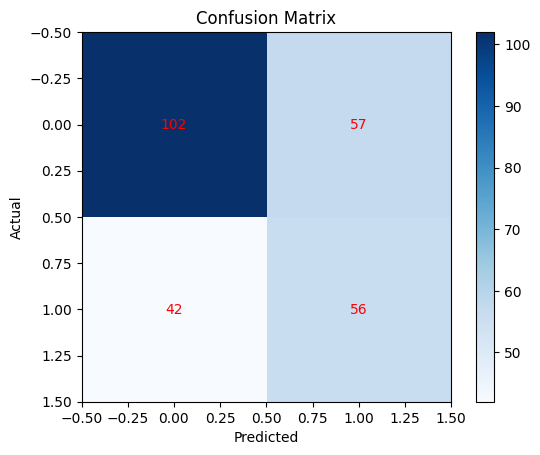

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# value annotate (optional)
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i][j], ha="center", va="center", color="red")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


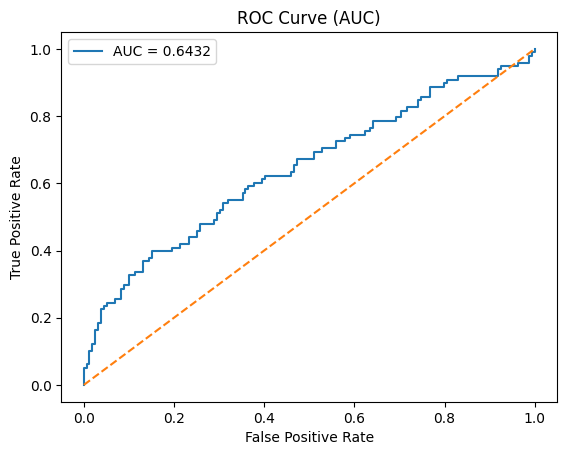

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AUC)")
plt.legend()
plt.show()



# -------- kNN ACCURACY --------

In [16]:
print("\n===== kNN ACCURACY (1,5,20) =====")
Xtr, Xte = sc.transform(train_feats), sc.transform(test_feats)
for k in [1,5,20]:
    knn = KNeighborsClassifier(k)
    knn.fit(Xtr, train_labels)
    print(f"k={k} → {knn.score(Xte, test_labels)}")


===== kNN ACCURACY (1,5,20) =====
k=1 → 0.603112840466926
k=5 → 0.7003891050583657
k=20 → 0.7354085603112841



# -------- LABEL EFFICIENCY --------

1% = 0.5408560311284046
5% = 0.7120622568093385
10% = 0.6459143968871596
25% = 0.6809338521400778
50% = 0.6731517509727627


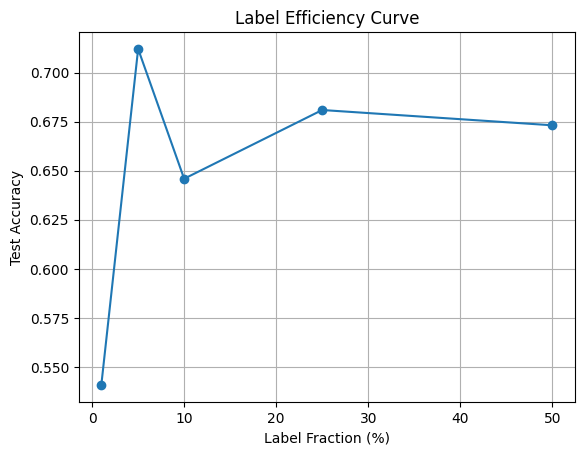

In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

fractions = [0.01, 0.05, 0.1, 0.25, 0.5]
accuracies = []

for f in fractions:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=f)
    idx, _ = next(sss.split(Xtr, train_labels))
    clf2 = LogisticRegression(max_iter=1000)
    clf2.fit(Xtr[idx], train_labels[idx])
    acc = clf2.score(Xte, test_labels)
    accuracies.append(acc)
    print(f"{int(f*100)}% =", acc)

# -----------------------------
# PLOT LABEL FRACTION VS ACCURACY
# -----------------------------
plt.figure()
plt.plot([f*100 for f in fractions], accuracies, marker='o')
plt.xlabel("Label Fraction (%)")
plt.ylabel("Test Accuracy")
plt.title("Label Efficiency Curve")
plt.grid(True)
plt.show()


# -------- EMBEDDING ANALYSIS --------

In [18]:
import umap
umap.umap_.check_array = lambda X, **kwargs: X   # PATCH for sklearn>=1.7 compatibility

print("\n===== EMBEDDING ANALYSIS =====")

pca = PCA(n_components=2).fit_transform(test_feats)
tsne = TSNE(n_components=2).fit_transform(test_feats)

# correct argument
um_emb = umap.UMAP(n_components=2).fit_transform(test_feats)

plt.scatter(pca[:,0], pca[:,1], c=test_labels, s=5)
plt.title("PCA"); plt.savefig("pca.png"); plt.close()

plt.scatter(tsne[:,0], tsne[:,1], c=test_labels, s=5)
plt.title("t-SNE"); plt.savefig("tsne.png"); plt.close()

plt.scatter(um_emb[:,0], um_emb[:,1], c=test_labels, s=5)
plt.title("UMAP"); plt.savefig("umap.png"); plt.close()

print("Silhouette =", silhouette_score(test_feats, test_labels, metric="cosine"))



===== EMBEDDING ANALYSIS =====
Silhouette = 0.04969508


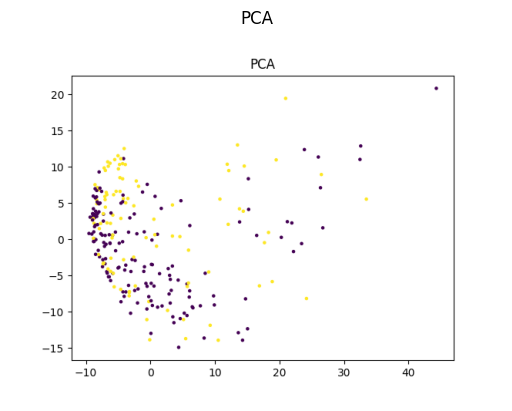

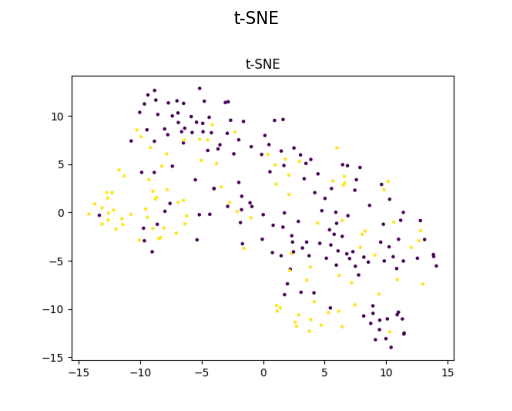

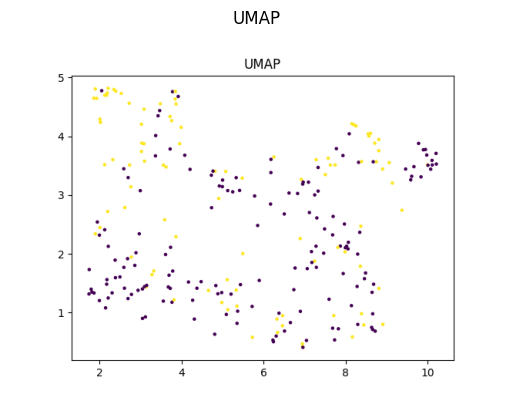

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# List of saved images
images = ["pca.png", "tsne.png", "umap.png"]
titles = ["PCA", "t-SNE", "UMAP"]

for img_file, title in zip(images, titles):
    img = Image.open(img_file)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()
